# Plot diagrams


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [54]:
metric_file_root_path = "../runs/"
x_value_order = ["1", "3", "10", "30", "100", "All"]
x_axis_title = "N.o. samples per class"
y_axis_title = "Macro F1 score"
score_column = "f1_macro"

aggregating_configs = {
    "-Derma": "Derma",
    # "-ImageNet_1k_SL_V1": "ImageNet SL",
    # "-ImageNet_1k_SL_WinKawaks": "ImageNet SL",
    # "-ImageNet_1k_SSL_SimCLR": "ImageNet SSL",
    "-ImageNet_1k_SSL_Dino": "ImageNet SSL",
    # "-ImageNet_AugReg": "ImageNet AugReg",
    "-Plant": "Plant SSL",
    # "-PDDD": "Plant SSL",
    # "-Random": "Random",
}

architecture_configs = {
    # "-ResNet50-": "ResNet50",  #
    # "-ViT_B16-": "ViT Base",  #
    "-ViT_T16-": "ViT Tiny",  #
}
model_configs = {
    "lr": "Logistic regression",  #
    "knn": "KNN",  #
}

dataset_configs = {
    # "PAD_UFES_20-ViT_T16-student": "PAD-UFES-20 (student)", #
    # "PAD_UFES_20-ViT_T16-teacher": "PAD-UFES-20 (teacher)", #
    # "DDI-ViT_T16-student": "DDI (student)", #
    # "DDI-ViT_T16-teacher": "DDI (teacher)", #
    # "HAM10000-ViT_T16-student": "HAM10000 (student)", #
    # "HAM10000-ViT_T16-teacher": "HAM10000 (teacher)", #
    # "Fitzpatrick17k-ViT_T16-student": "Fitzpatrick17k (student)", #
    # "Fitzpatrick17k-ViT_T16-teacher": "Fitzpatrick17k (teacher)", #
    "Cassava-ViT_T16-student": "Cassava (student)", #
    "Cassava-ViT_T16-teacher": "Cassava (teacher)", #

    # "PAD_UFES_20-ResNet50": "PAD-UFES-20", #
    # "DDI-ResNet50": "DDI", #
    # "HAM10000-ResNet50": "HAM10000", #
    # "Fitzpatrick17k-ResNet50": "Fitzpatrick17k", #
    # "Cassava-ResNet50": "Cassava", #
    # "PlantVillage-ResNet50": "PlantVillage", #
    # "PlantDoc-ResNet50": "PlantDoc", #
    # "PlantDataset-ResNet50": "PlantDataset", #
}


In [55]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"


def distribution_check(configs, column):
    total_counter = 0
    for key in configs:
        number_of_matching_rows = column.str.contains(key).sum()
        print(f"{key} -> {number_of_matching_rows} matches")
        total_counter += number_of_matching_rows

    total_length = len(column)
    if total_length != total_counter:
        print(f"{total_length} != {total_counter}")
    assert total_length == total_counter

def load_pd(dataset):
    metric_file_name = f"{dataset}-metrics.txt"
    metric_file = open(os.path.join(metric_file_root_path, metric_file_name), "r")
    content = metric_file.read().replace("\n", "").replace("}{", "},{")
    entries = json.loads("[" + content + "]")
    print(f"Read {len(entries)} entries in {metric_file_name}")
    return pd.DataFrame.from_records(entries)

Read 6012 entries in Cassava-ViT_T16-student-metrics.txt
feature_identifier
../datasets/intermediate-features/Cassava-ViT_T16-Derma.csv                       1002
../datasets/intermediate-features/Cassava-ViT_T16-ImageNet_1k_SL_WinKawaks.csv    1002
../datasets/intermediate-features/Cassava-ViT_T16-ImageNet_1k_SSL_Dino.csv        1002
../datasets/intermediate-features/Cassava-ViT_T16-ImageNet_AugReg.csv             1002
../datasets/intermediate-features/Cassava-ViT_T16-Plant.csv                       1002
../datasets/intermediate-features/Cassava-ViT_T16-Random.csv                      1002
dtype: int64
Read 3006 entries in Cassava-ViT_T16-teacher-metrics.txt
feature_identifier
../datasets/intermediate-features/Cassava-ViT_T16-teacher-Derma.csv                   1002
../datasets/intermediate-features/Cassava-ViT_T16-teacher-ImageNet_1k_SSL_Dino.csv    1002
../datasets/intermediate-features/Cassava-ViT_T16-teacher-Plant.csv                   1002
dtype: int64


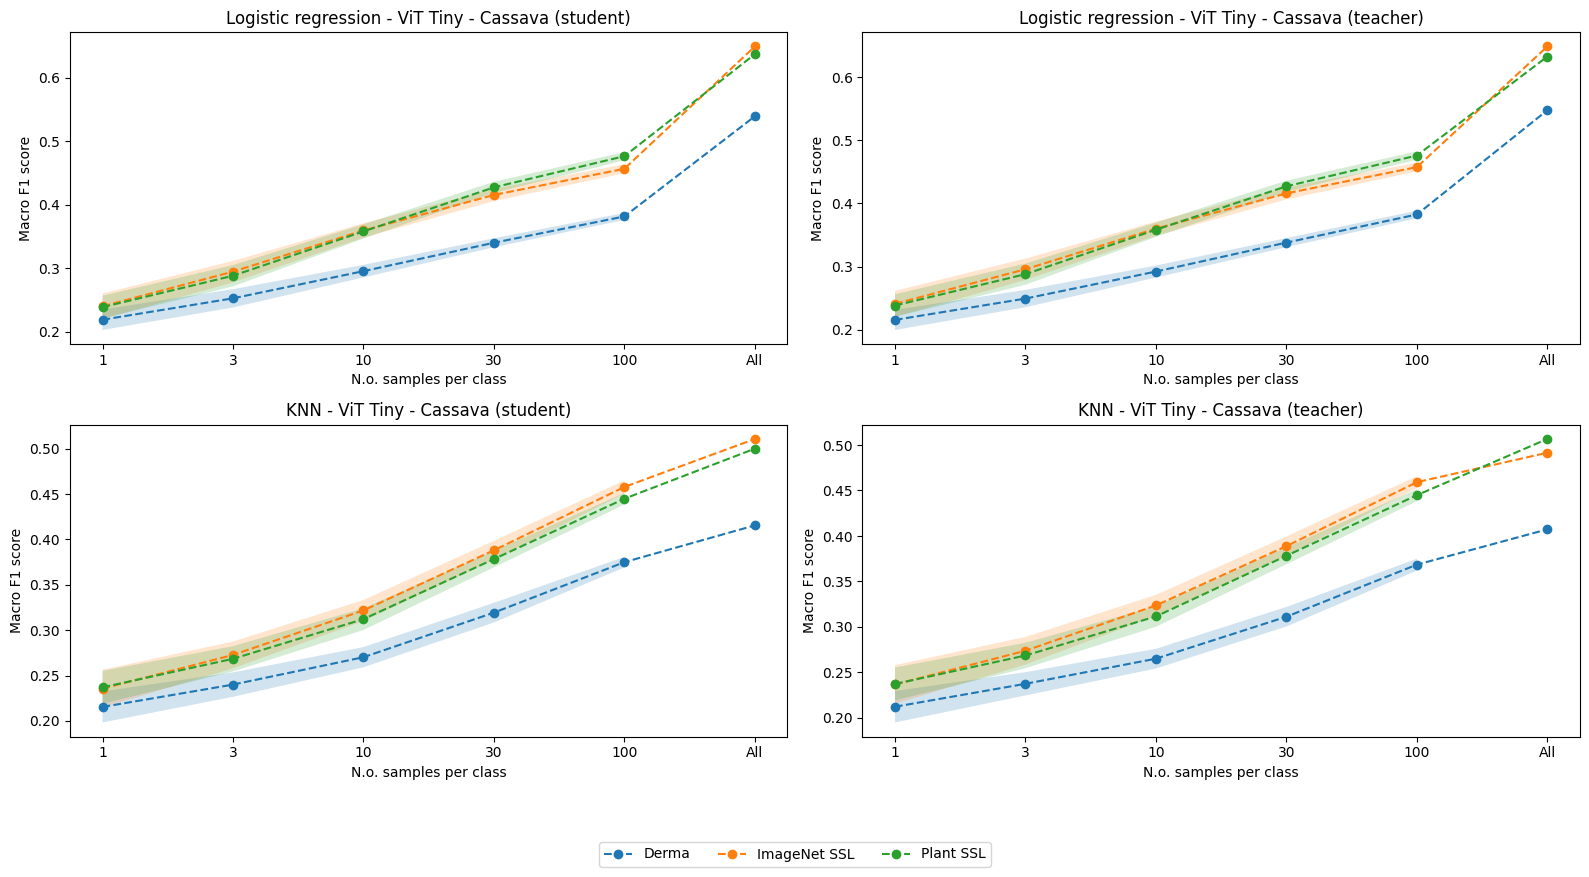

In [56]:
fig, ax = plt.subplots(
    len(architecture_configs) * len(model_configs),
    len(dataset_configs),
    figsize=(16, 8),
    squeeze=False,
)

for column, dataset_key in enumerate(dataset_configs):
    dataset_label = dataset_configs[dataset_key]
    df = load_pd(dataset_key)
    print(df.groupby("feature_identifier").size())

    # distribution_check(model_configs, df["model_name"])
    # distribution_check(dataset_configs, df["feature_identifier"])
    # distribution_check(architecture_configs, df["feature_identifier"])
    # distribution_check(aggregating_configs, df["feature_identifier"])

    df["number_of_samples"] = df["number_of_samples"].apply(number_to_string)
    df_data = df

    for row_1, arch_key in enumerate(architecture_configs):
        arch_label = architecture_configs[arch_key]
        df_arch = df_data[df_data["feature_identifier"].str.contains(arch_key)]

        for agg_key in aggregating_configs:
            agg_label = aggregating_configs[agg_key]
            df_agg = df_arch[
                df_arch["feature_identifier"].str.contains(agg_key)
            ]

            for row_2, model_key in enumerate(model_configs):
                model_label = model_configs[model_key]
                df_model = df_agg[
                    df_agg["model_name"].str.contains(model_key)
                ]
                row = row_1 * len(model_configs) + row_2
                df_val = df_model.groupby(["number_of_samples"]).agg(
                    {"f1_macro": ["mean", "std"]}
                )
                df_val.columns = df_val.columns.droplevel(0)
                df_val = df_val.reset_index()
                df_val.set_index("number_of_samples", inplace=True)
                df_val = df_val.reindex(index=x_value_order)

                std_err = df_val["std"] / np.sqrt(len(df_val))

                ax[row][column].fill_between(
                    df_val.index,
                    df_val["mean"] - std_err,
                    df_val["mean"] + std_err,
                    alpha=0.2,
                )
                # ax[row][column].plot(df_val["mean"], linestyle='dashed',label=label) # ,label=[label]
                df_val.plot.line(
                    ax=ax[row][column],
                    y=["mean"],
                    # x=["number_of_samples"], NOTE: index is x-axis as default
                    label=[agg_label],
                    # style=['o--']
                    marker='o',
                    linestyle='--'
                )

                # ax[row][column].set_ylim([0, 0.6])
                ax[row][column].set_title(f"{model_label} - {arch_label} - {dataset_label}")
                ax[row][column].set_ylabel(y_axis_title)
                ax[row][column].set_xlabel(x_axis_title)
                ax[row][column].get_legend().remove()
                # ax[row][column].set_xlim([xmin, xmax])
                # ax[row][column].set_ylim([0, 1])

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(labels)
)
plt.show()

In [57]:
df.groupby("number_of_samples").mean()

,selection_seed,accuracy,balanced_accuracy,f1_weighted,f1_micro,f1_macro,best_k
number_of_samples,,,,,,,
1,49.5,0.328290,0.272825,0.351167,0.328290,0.230231,1.000000
10,49.5,0.422160,0.367825,0.461462,0.422160,0.318467,5.716667
100,49.5,0.568705,0.476826,0.592289,0.568705,0.431360,50.346667
3,49.5,0.355162,0.312473,0.394161,0.355162,0.268847,1.103333
30,49.5,0.500083,0.425528,0.531447,0.500083,0.376537,21.126667
All,NaN,0.736760,0.512815,0.712556,0.736760,0.538929,6.666667


In [58]:
# df_knn = df[df["model_name"] == "knn"]
# print("Min: " + str(df_knn["best_k"].min()))
# print("Max: " + str(df_knn["best_k"].max()))
# df_knn["best_k"].plot.hist(bins=100)

# NOTE: Do not put this graphic into the report, because it is highly biased and could confuse readers

In [59]:
# x_values_random = [
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "KNN Swin-T",
#     "KNN Swin-T",
#     "LogReg Swin-T",
#     "LogReg Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_random = [
#     0.446064139941691,
#     0.43440233236151604,
#     0.43440233236151604,
#     0.2944606413994169,
#     0.32653061224489793,
#     0.40233236151603496,
#     0.45481049562682213,
#     0.36151603498542273,
#     0.40233236151603496,
#     0.5451895043731778,
#     0.4752186588921283,
#     0.4956268221574344,
# ]
# x_values_imagenet = [
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_imagenet = [
#     0.5714285714285714,
#     0.565597667638484,
#     0.2565597667638484,
#     0.4897959183673469,
#     0.5830903790087464,
#     0.7346938775510204,
# ]
# x_values_pddd = [
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_pddd = [
#     0.4752186588921283,
#     0.42565597667638483,
#     0.6122448979591837,
#     0.6384839650145773,
# ]

In [60]:
# plt.scatter(x_values_random, y_values_random)
# plt.scatter(x_values_imagenet, y_values_imagenet)
# plt.scatter(x_values_pddd, y_values_pddd)
# plt.gca().set_ylabel("Accuracy")  # gca = get current axes
# plt.legend(["Random", "ImageNet", "PDDD"])
# plt.title("Cassava comparison")
# plt.show()